In [91]:
import numpy as np
import math
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import Configuration
from importlib import reload
reload(Configuration)
from Configuration import ITERATIONS, MIN_PRICE, MAX_PRICE, COST, DAYS, INTERVAL_LENGTH, N_USERS

## Single Product

### Single customer:

In [92]:
price = 0.15
noise_variance = 0.01
def conversion_probability(p):
    p = 1 - np.exp(p/MAX_PRICE - 1) + np.random.normal(0, noise_variance)  # expected demand curve in terms of probability of purchase
    # mask probabilities to be in [0, 1]
    if p.__class__ == np.ndarray:
        p[p < 0] = 0
        p[p > 1] = 1
        return p
    return 0 if p < 0 else 1 if p > 1 else p

sold = np.random.binomial(1, conversion_probability(price)) #  binomial(1) = bernoulli

print(f'Probability of purchase at price {price}: {conversion_probability(price)}')

# will the customer buy my product at this price?
print(f'Sold? {bool(sold)}')

Probability of purchase at price 0.15: 0.5712024250395615
Sold? False


### Multiple customers:

In [93]:
n_customers = 100 # the more customers we have, the more the estimate will converge to the true probability

sales = np.random.binomial(n_customers, conversion_probability(price))

# will the customer buy my product at this price?
print(f'How many sales? {sales}')

How many sales? 53


### Expectation over multiple customers:

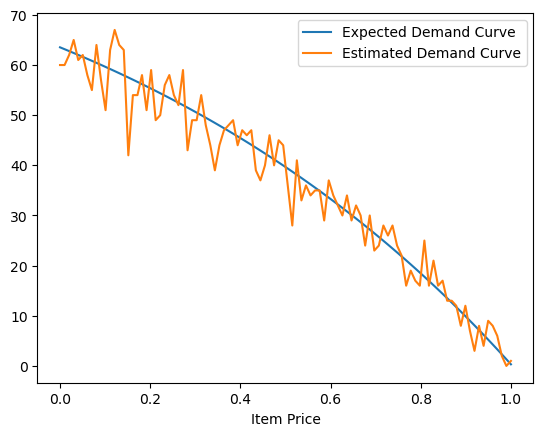

In [94]:
# we need a continuous range of prices (=> a large number of prices)
NUMBER_OF_PRICES = 100
prices = np.linspace(MIN_PRICE, MAX_PRICE, NUMBER_OF_PRICES)
cost = COST
n_customers = N_USERS

expected_demand_curve = n_customers*conversion_probability(prices)

estimated_demand_curve = np.random.binomial(n_customers, conversion_probability(prices))

plt.figure()
plt.plot(prices, expected_demand_curve, label='Expected Demand Curve')
plt.plot(prices, estimated_demand_curve, label='Estimated Demand Curve')
plt.xlabel('Item Price')
plt.legend()
plt.show();

In [95]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        # we sample at each round without computing everything a priori, to save memory
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t #we can deal in the future with a time varying number of customers
        return d_t, r_t

In [96]:
env = PricingEnvironment(conversion_probability=conversion_probability, cost=COST)
env.round(price, n_customers)

(58, 2.8999999999999995)

In [97]:
# use this in project, better than scikit learn one
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [98]:
# From the agent's point of view, action set is [0,1]. If the actual actions are outside this
# set, we can always perform a rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        # beta is computed from gamma, which represents the maximum information gain at time t
        # gamma grows as log of t (squared), and also exponentially with the dimension of the action space (1 in this case)
        # so if we had three products to choose from, gamma would grow as log(t)^(2*3) = log(t)^6
        # gamma is the pure exploration term, indicating how much exploring could help us
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T))) # T involved -> not an anytime algorithm
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        # sigma is the information we have about the uncertainty of the model, obtained from the GP (and so takes information
        # also from the rewards of the other arms)
        # beta is the exploration parameter, it is obtained from the UCB1 algorithm

        # so in summary this algorithm works a bit like UCB1, but it uses a GP to estimate the rewards of the arms, so it
        # works in a different action space, and it uses the uncertainty of the GP to decide the exploration-exploitation tradeoff
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

Best price: 0.595959595959596


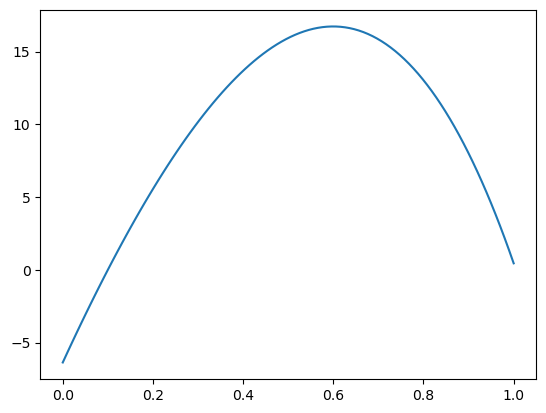

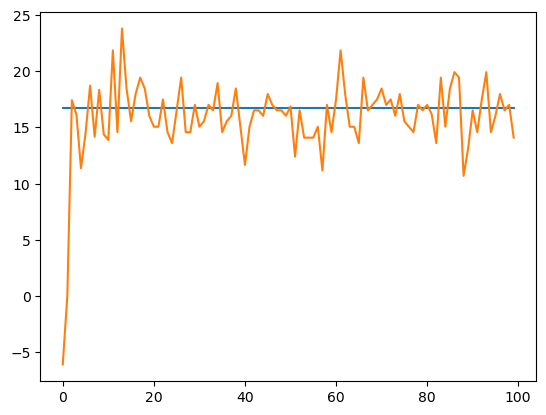

In [99]:
# we don't need rescaling as we are working in the [0,1] action space

reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(MAX_PRICE, n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

T = 100
min_price, max_price = MIN_PRICE, MAX_PRICE
n_customers = N_USERS
cost = COST
agent = GPUCBAgent(T)
np.random.seed(RANDOM_SEED)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

# let's compute the clairvoyant
prices = prices
profit_curve = reward_function(prices, n_customers*conversion_probability(p=prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

print(f'Best price: {best_price}')
plt.plot(prices, profit_curve)
plt.show()
plt.plot(expected_clairvoyant_rewards)

agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    d_t, r_t = env.round(p_t, n_t=n_customers)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

plt.plot(agent_rewards)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

In [100]:
profits = agent.reward_hist

(100,)


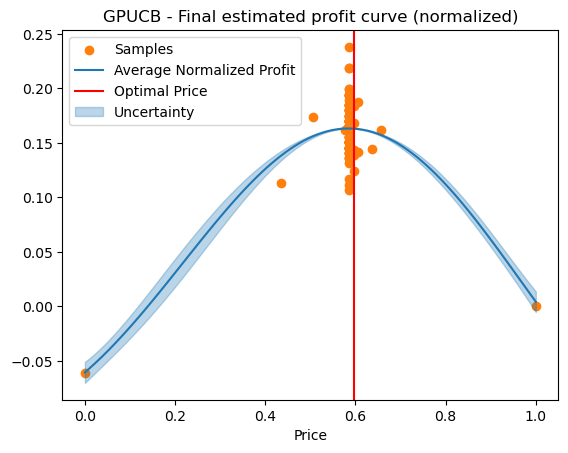

In [101]:
gp = RBFGaussianProcess(scale=2)
gp.fit(agent.action_hist, profits)
print(prices.shape)
mu, sigma = gp.predict(prices)
plt.scatter(agent.action_hist, profits, label='Samples', color='C1')
plt.plot(prices, mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(prices, mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

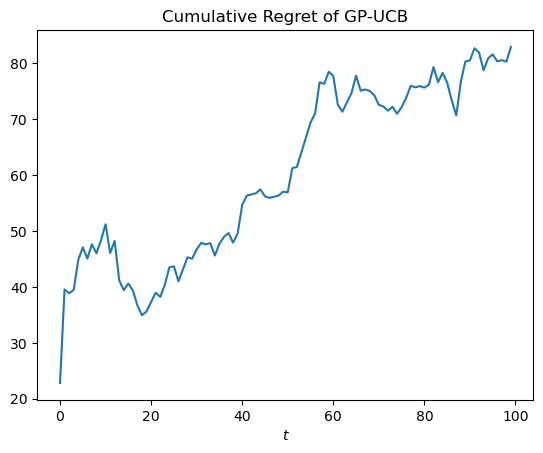

In [102]:
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();

### Another drawback: instability! Mainly due to Gaussian Processes tendency to overfit.

### The algorithm seems to perform better than a UCB1 strategy with price discretization, but we need a more reliable estimation

In [103]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

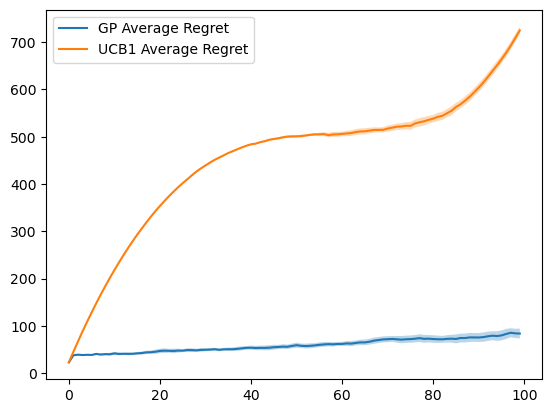

In [104]:
n_epochs = 5

gp_all_cumulative_regrets = []
ucb_all_cumulative_regrets = []
for i in range(n_epochs):
    gp_agent = GPUCBAgent(T)
    ucb1_agent = UCB1Agent(K=NUMBER_OF_PRICES, T=T, range=maximum_profit)

    np.random.seed(10*i)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

    gp_agent_rewards = np.array([])
    ucb_agent_rewards = np.array([])
    for t in range(T):
        p_t = gp_agent.pull_arm()
        d_t, r_t = env.round(p_t, n_t=n_customers)
        gp_agent.update(r_t/n_customers)
        gp_agent_rewards = np.append(gp_agent_rewards, r_t)

        p_t = ucb1_agent.pull_arm()
        p_t = prices[p_t]
        d_t, r_t = env.round(p_t, n_t=n_customers)
        ucb1_agent.update(r_t)
        ucb_agent_rewards = np.append(ucb_agent_rewards, r_t)

    gp_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-gp_agent_rewards))

    ucb_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-ucb_agent_rewards))

gp_all_cumulative_regrets = np.array(gp_all_cumulative_regrets)
ucb_all_cumulative_regrets = np.array(ucb_all_cumulative_regrets)

gp_average_cumulative_regret = gp_all_cumulative_regrets.mean(axis=0)
gp_cumulative_regret_std = gp_all_cumulative_regrets.std(axis=0)

ucb_average_cumulative_regret = ucb_all_cumulative_regrets.mean(axis=0)
ucb_cumulative_regret_std = ucb_all_cumulative_regrets.std(axis=0)

plt.plot(np.arange(T), gp_average_cumulative_regret, label='GP Average Regret')
plt.fill_between(np.arange(T),
                gp_average_cumulative_regret-gp_cumulative_regret_std/np.sqrt(n_epochs),
                gp_average_cumulative_regret+gp_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.plot(np.arange(T), ucb_average_cumulative_regret, label='UCB1 Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_cumulative_regret-ucb_cumulative_regret_std/np.sqrt(n_epochs),
                ucb_average_cumulative_regret+ucb_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.legend()
plt.show();

### The performance gap is clear. Why the weird behavior of UCB1's average cumulative regret?

### Note: with $T=200$, UCB1 has to spend half of its time just to try all arms once!

### What would be the discretization prescribed by theory?

In [105]:
epsilon = T**(-0.33)
K = int(1/epsilon)
K

4

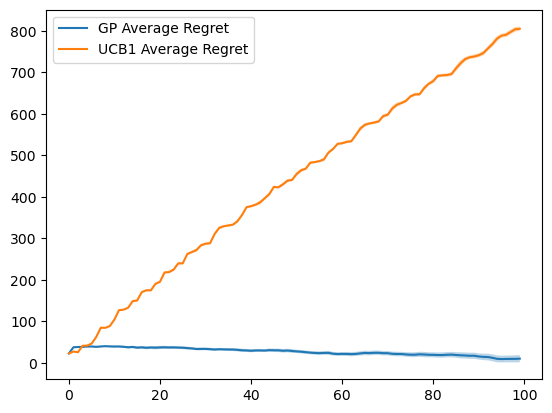

In [106]:
# let's compute the clairvoyant
prices = np.linspace(min_price, max_price, K)
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_epochs = 10

gp_all_cumulative_regrets = []
ucb_all_cumulative_regrets = []
for i in range(n_epochs):
    gp_agent = GPUCBAgent(T)
    ucb1_agent = UCB1Agent(K, T, range=maximum_profit)

    np.random.seed(10*i)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

    gp_agent_rewards = np.array([])
    ucb_agent_rewards = np.array([])
    for t in range(T):
        p_t = gp_agent.pull_arm()
        d_t, r_t = env.round(p_t, n_t=n_customers)
        gp_agent.update(r_t/n_customers)
        gp_agent_rewards = np.append(gp_agent_rewards, r_t)

        p_t = ucb1_agent.pull_arm()
        p_t = prices[p_t]
        d_t, r_t = env.round(p_t, n_t=n_customers)
        ucb1_agent.update(r_t)
        ucb_agent_rewards = np.append(ucb_agent_rewards, r_t)

    gp_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-gp_agent_rewards))

    ucb_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-ucb_agent_rewards))

gp_all_cumulative_regrets = np.array(gp_all_cumulative_regrets)
ucb_all_cumulative_regrets = np.array(ucb_all_cumulative_regrets)

gp_average_cumulative_regret = gp_all_cumulative_regrets.mean(axis=0)
gp_cumulative_regret_std = gp_all_cumulative_regrets.std(axis=0)

ucb_average_cumulative_regret = ucb_all_cumulative_regrets.mean(axis=0)
ucb_cumulative_regret_std = ucb_all_cumulative_regrets.std(axis=0)

plt.plot(np.arange(T), gp_average_cumulative_regret, label='GP Average Regret')
plt.fill_between(np.arange(T),
                gp_average_cumulative_regret-gp_cumulative_regret_std/np.sqrt(n_epochs),
                gp_average_cumulative_regret+gp_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.plot(np.arange(T), ucb_average_cumulative_regret, label='UCB1 Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_cumulative_regret-ucb_cumulative_regret_std/np.sqrt(n_epochs),
                ucb_average_cumulative_regret+ucb_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.legend()
plt.show();

### Comparable performances, but this time the regret seems to have at least a sub-linear behavior ($\mathcal{O}(T^\frac{2}{3}\log(T))$).

### Regret of GP-UCB:
### $$ R_T = \mathcal{O}(\sqrt{T}\gamma_T) =  \mathcal{O}(\sqrt{T}\log(T)^{d+1})$$
### where $d$ is the dimension of the action space, in our case $d=1$. Note that the total information gain term scales exponentially with the dimension of the action space -> curse of dimensionality!

### Multi-dimensional action spaces ($d>1$) are very important in dynamic pricing, since they model the scenario in which a seller is offering multiple product, with possibly correlated demands. GP-UCB can be extended to the multi-dimensional scenario, see the reference above.

## 2 Products

### Single customer:

In [107]:
price = 0.75, 0.01
noise_variance = 0.001
def probability_single_product(p):
    p = 1 - np.exp(p/MAX_PRICE - 1) + np.random.normal(0, noise_variance)  # expected demand curve in terms of probability of purchase
    # mask probabilities to be in [0, 1]
    if p.__class__ == np.ndarray:
        p[p < 0] = 0
        p[p > 1] = 1
        return p
    return 0 if p < 0 else 1 if p > 1 else p

def conversion_probability(prices):   
    p1 = probability_single_product(prices[0])
    p2 = probability_single_product(prices[1])
    return np.array([p1*(1-p2), p2*(1-p1)])

sold = np.random.binomial(1, conversion_probability(price)) #  binomial(1) = bernoulli

print(f'Probability of purchase at price {price}: {conversion_probability(price)}')

# will the customer buy my products at this price?
print(f'first product sold? {bool(sold[0])}')
print(f'second product sold? {bool(sold[1])}')

Probability of purchase at price (0.75, 0.01): [0.08171546 0.49066077]
first product sold? False
second product sold? True


### Multiple customers:

In [108]:
n_customers = 100 # the more customers we have, the more the estimate will converge to the true probability

sales = np.random.binomial(n_customers, conversion_probability(price))

# will the customer buy my product at this price?
print(f'How many sales for each product? {sales}')

How many sales for each product? [10 51]


### Expectation over multiple customers:

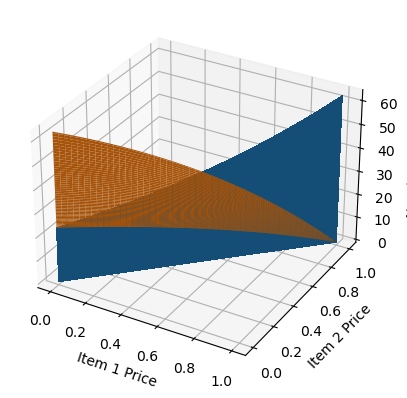

In [109]:
# we need a 2-dimensional continuous range of prices
cost = COST
n_customers = N_USERS
discretization = 100
price_set = np.linspace(MIN_PRICE, MAX_PRICE, discretization)
prices = np.zeros((2, discretization, discretization))
prices[0, :, :] = price_set.reshape(-1, 1)
prices[1, :, :] = price_set.reshape(1, -1)

expected_demand_curves = n_customers*conversion_probability(prices)

estimated_demand_curves = np.random.binomial(n_customers, conversion_probability(prices))
# we must plot in 3D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(price_set, price_set, expected_demand_curves[0, :, :],
                       linewidth=0, antialiased=False)
ax.plot_surface(price_set, price_set, expected_demand_curves[1, :, :])
#ax.plot_surface(price_set, price_set, estimated_demand_curves[0, :, :], label='Estimated Demand Curve 1')
#ax.plot_surface(price_set, price_set, estimated_demand_curves[1, :, :], label='Estimated Demand Curve 2')
ax.set_xlabel('Item 1 Price')
ax.set_ylabel('Item 2 Price')
ax.set_zlabel('Number of Sales')
plt.show();

### just try different prices for product 1 and see the effects on product 2

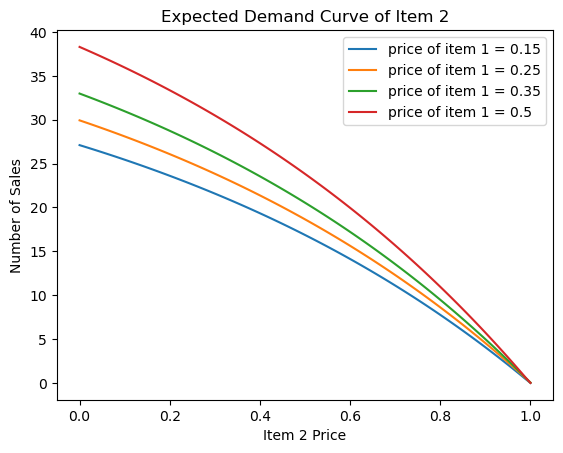

In [110]:
# let's try different prices for product 1 and see how demand curve of product 2 changes
p1 = 0.15, 0.25, 0.35, 0.5
p1 = np.array(p1)

prices = np.zeros((2, p1.size, discretization))
prices[0, :, :] = p1.reshape(-1, 1)
prices[1, :, :] = price_set.reshape(1, -1)

for i in range(len(p1)):
    p = prices[:, i, :]
    expected_demand_curve = n_customers*conversion_probability(p)
    plt.plot(price_set, expected_demand_curve[1, :], label='price of item 1 = '+str(p1[i]))
    plt.xlabel('Item 2 Price')
    plt.ylabel('Number of Sales')
    plt.legend()
plt.title('Expected Demand Curve of Item 2')
plt.show();

### Which is the best possible couple of prices?

Best price: [0.64646465 0.77777778]
Best price: [0.64646465 0.77777778]


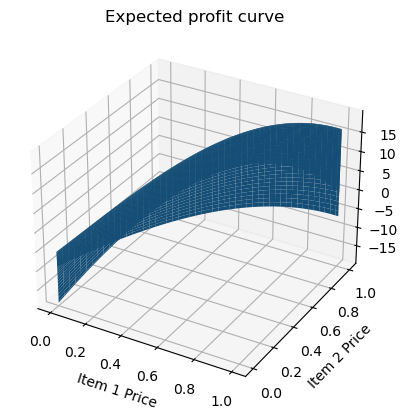

In [111]:
# best prices computation
costs = np.array([0.1, 0.3])


def reward_function(prices, costs, n_sales):
    costs_extended = np.zeros((2, discretization, discretization))
    costs_extended[0, :, :] = costs[0]
    costs_extended[1, :, :] = costs[1]
    return (prices-costs_extended)*n_sales

# let's compute the clairvoyant
price_set = np.linspace(min_price, max_price, discretization)
prices = np.zeros((2, discretization, discretization))
prices[0, :, :] = price_set.reshape(-1, 1)
prices[1, :, :] = price_set.reshape(1, -1)
profit_curves = reward_function(prices, costs, n_customers*conversion_probability(prices=prices))
profit_curve = np.sum(profit_curves, axis=0)
best_price_index = np.unravel_index(profit_curve.argmax(), profit_curve.shape)
idx_p1, idx_p2 = best_price_index
best_price = prices[:, idx_p1, idx_p2]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

print(f'Best price: {best_price}')
print(f'Best price: {best_price}')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(price_set, price_set, profit_curve, label='Expected Profit Curve')
ax.set_xlabel('Item 1 Price')
ax.set_ylabel('Item 2 Price')
ax.set_zlabel('Profit')
plt.title("Expected profit curve")
plt.show()

### Let's build the environment for multiple products

In [112]:
class PricingEnvironment:
    def __init__(self, conversion_probabilities, costs):
        self.conversion_probabilities = conversion_probabilities
        self.costs = np.array(costs)

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probabilities(p_t))
        r_t = np.sum((p_t - self.costs)*d_t)
        return d_t, r_t

In [113]:
costs = 0.1, 0.1 # let's assume the costs are the same for both products
price = 0.15, 0.25
env = PricingEnvironment(conversion_probabilities=conversion_probability, costs=costs)
env.round(price, n_customers)

(array([22, 18]), 3.7999999999999994)

In [114]:
import numpy as np

class RBFGaussianProcess:
    def __init__(self, scale=0.1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        # Adjusted to handle multi-dimensional inputs
        a = a.reshape(-1, 2)
        b = b.reshape(-1, 2)
        sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2 * np.dot(a, b.T)
        return np.exp(-self.scale * sqdist)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x, y = np.array(x), np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1, 1)
            self.x = x.reshape(-1, 2)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([[1 + self.reg]]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)
        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)
        return mu_hat.ravel(), sigma_hat.ravel()


### Let's build the agent (specific for 2 products)

In [127]:
# From the agent's point of view, action set is [0,1]^2. If the actual actions are outside this
# set, we can always perform a rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        price_set = np.linspace(0, 1, discretization)
        self.arms = np.array(np.meshgrid(price_set, price_set)).T.reshape(-1, 2)
        self.gp = RBFGaussianProcess(scale=10).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization*discretization)
        self.sigma_t = np.zeros(discretization*discretization)
        # beta is computed from gamma, which represents the maximum information gain at time t
        # gamma grows as log of t (squared), and also exponentially with the dimension of the action space (2 in this case)
        # so if we had three products to choose from, gamma would grow as log(t)^(2*3) = log(t)^6
        # gamma is the pure exploration term, indicating how much exploring could help us
        self.gamma = lambda t: np.log(t+1)**4
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T))) # T involved -> not an anytime algorithm
        self.N_pulls = np.zeros(discretization*discretization)
        self.t = 0
    
    def pull_arm(self):
        # sigma is the information we have about the uncertainty of the model, obtained from the GP (and so takes information
        # also from the rewards of the other arms)
        # beta is the exploration parameter, it is obtained from the UCB1 algorithm

        # so in summary this algorithm works a bit like UCB1, but it uses a GP to estimate the rewards of the arms, so it
        # works in a different action space, and it uses the uncertainty of the GP to decide the exploration-exploitation tradeoff
        self.mu_t, self.sigma_t = self.gp.predict(self.arms)
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t =np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

In [116]:
"""discretization = 100
price_set = np.linspace(0, 1, discretization)
price_grid = np.array(np.meshgrid(price_set, price_set)).T.reshape(-1, 2)

# Simulated rewards
rewards = np.random.rand(price_grid.shape[0])

# Initialize and fit the GP
gp = RBFGaussianProcess(scale=2).fit(price_grid, rewards)

# Predict for new prices
new_price_pairs = np.array([[0.2, 0.3], [0.5, 0.5]])
mu_hat, sigma_hat = gp.predict(new_price_pairs)
print("Predicted means: ", mu_hat)
print("Predicted variances: ", sigma_hat)"""


'discretization = 100\nprice_set = np.linspace(0, 1, discretization)\nprice_grid = np.array(np.meshgrid(price_set, price_set)).T.reshape(-1, 2)\n\n# Simulated rewards\nrewards = np.random.rand(price_grid.shape[0])\n\n# Initialize and fit the GP\ngp = RBFGaussianProcess(scale=2).fit(price_grid, rewards)\n\n# Predict for new prices\nnew_price_pairs = np.array([[0.2, 0.3], [0.5, 0.5]])\nmu_hat, sigma_hat = gp.predict(new_price_pairs)\nprint("Predicted means: ", mu_hat)\nprint("Predicted variances: ", sigma_hat)'

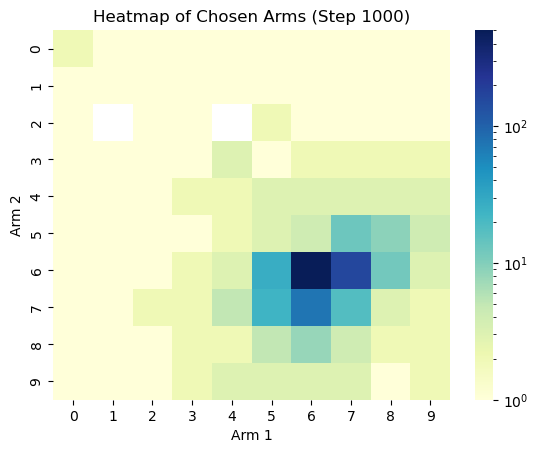

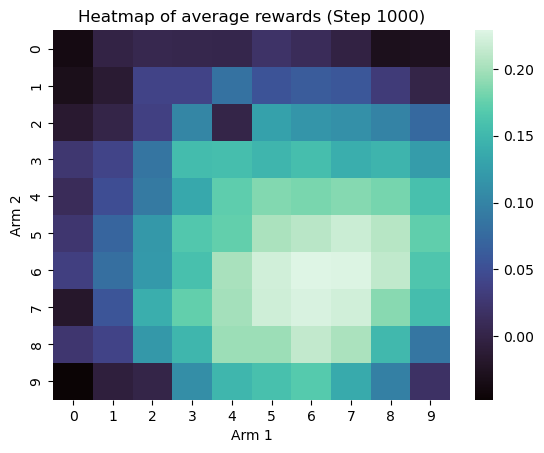

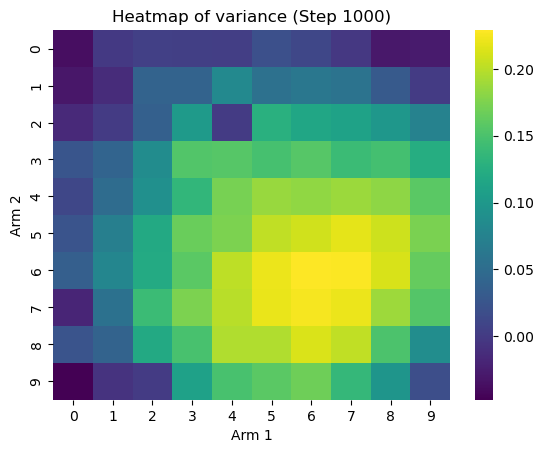

Best price: [0.66666667 0.66666667]


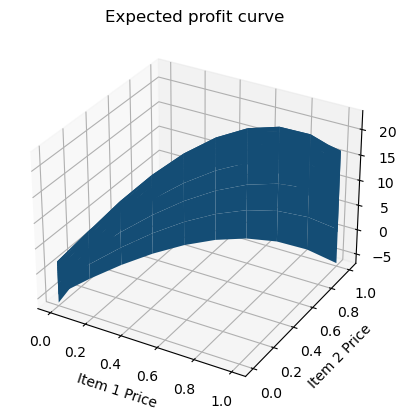

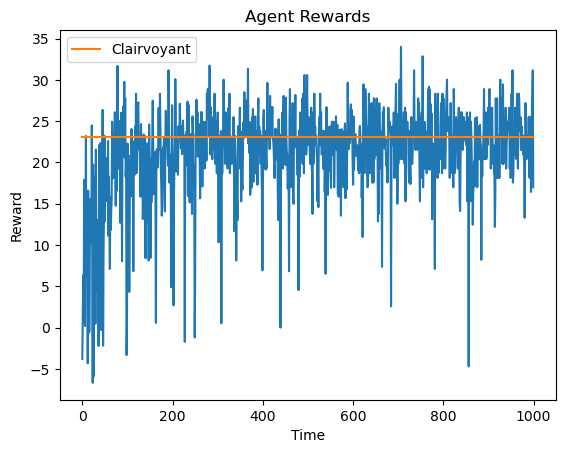

In [130]:
import seaborn as sns
from time import sleep
from matplotlib.colors import LogNorm
from IPython.display import clear_output

def reward_function(prices, costs, n_sales):
    costs_extended = np.zeros((2, discretization, discretization))
    costs_extended[0, :, :] = costs[0]
    costs_extended[1, :, :] = costs[1]
    return (prices-costs_extended)*n_sales

maximum_profit = reward_function(MAX_PRICE, costs, n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

T = 1000
min_price, max_price = MIN_PRICE, MAX_PRICE
n_customers = N_USERS
costs = COST, COST
discretization = 10
agent = GPUCBAgent(T, discretization=discretization)
np.random.seed(RANDOM_SEED)
env = PricingEnvironment(conversion_probabilities=conversion_probability, costs=costs)

# let's compute the clairvoyant
price_set = np.linspace(min_price, max_price, discretization)
prices = np.zeros((2, discretization, discretization))
prices[0, :, :] = price_set.reshape(-1, 1)
prices[1, :, :] = price_set.reshape(1, -1)
profit_curves = reward_function(prices, costs, n_customers*conversion_probability(prices=prices))
profit_curve = np.sum(profit_curves, axis=0)
best_price_index = np.unravel_index(profit_curve.argmax(), profit_curve.shape)
idx_p1, idx_p2 = best_price_index
best_price = prices[:, idx_p1, idx_p2]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

print(f'Best price: {best_price}')
"""fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(price_set, price_set, profit_curve, label='Expected Profit Curve')
ax.set_xlabel('Item 1 Price')
ax.set_ylabel('Item 2 Price')
ax.set_zlabel('Profit')
plt.show()"""

# Initialize heatmap tracking
heatmap_pulls = np.zeros((discretization, discretization))
heatmap_mu = np.zeros((discretization, discretization))
heatmap_sigma = np.zeros((discretization, discretization))

# Set up the heatmap plot
plt.ion()

agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    d_t, r_t = env.round(p_t, n_t=n_customers)
    #print("pulled arm price: ", p_t, "reward: ", r_t)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

    # Update heatmap tracking
    idx_p1, idx_p2 = agent.a_t % discretization, agent.a_t // discretization
    heatmap_pulls[idx_p1, idx_p2] += 1
    heatmap_mu[idx_p1, idx_p2] = agent.mu_t[agent.a_t]
    heatmap_sigma[idx_p1, idx_p2] = agent.sigma_t[agent.a_t]
    
    # Update the heatmap every 10 time steps
    if (t + 1) % 10 == 0:
        clear_output(wait=True)
        sns.heatmap(heatmap_pulls, cmap="YlGnBu", norm=LogNorm())
        plt.xlabel("Arm 1")
        plt.ylabel("Arm 2")
        plt.title(f"Heatmap of Chosen Arms (Step {t+1})")
        plt.show()
        sns.heatmap(heatmap_mu, cmap="mako")
        plt.xlabel("Arm 1")
        plt.ylabel("Arm 2")
        plt.title(f"Heatmap of average rewards (Step {t+1})")
        plt.show()
        sns.heatmap(heatmap_mu, cmap="viridis")
        plt.xlabel("Arm 1")
        plt.ylabel("Arm 2")
        plt.title(f"Heatmap of variance (Step {t+1})")
        plt.show()

print(f'Best price: {best_price}')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(price_set, price_set, profit_curve, label='Expected Profit Curve')
ax.set_xlabel('Item 1 Price')
ax.set_ylabel('Item 2 Price')
ax.set_zlabel('Profit')
plt.title("Expected profit curve")
plt.show()


ax = plt.figure()
plt.plot(agent_rewards)
plt.plot(expected_clairvoyant_rewards, label='Clairvoyant')
plt.title('Agent Rewards')
plt.xlabel('Time')
plt.ylabel('Reward')
plt.legend()
plt.show()

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

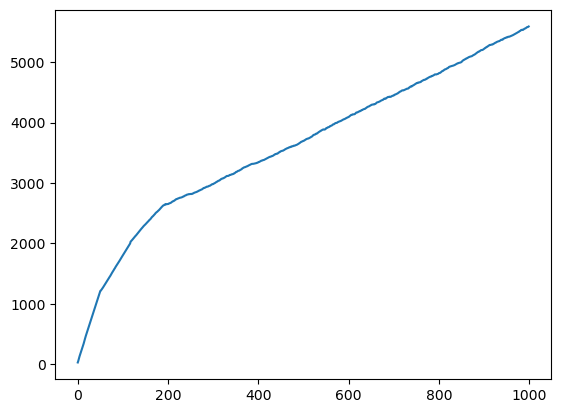

In [ ]:
plt.plot(cumulative_regret)